### Dependencies imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_recall_fscore_support,
    average_precision_score
)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek




In [35]:
df= pd.read_csv("C:/sai files/projects/predictive-maintenance-end2end/test.csv")

### 2. Scope of Final Modeling Notebook Scope

This notebook focuses on **consolidation, validation, and final decision-making**, building on insights from prior exploratory and preprocessing analyses.

---

**Objective**

The objectives of this notebook are to:

- Summarize key insights from **EDA** and **baseline preprocessing experiments**
- Narrow down the modeling scope to **final candidate models and strategies**
- Perform a **focused comparison of imbalance-handling approaches**
- Select a **final modeling configuration** for production-grade training

> This notebook does **not** introduce new feature engineering or hyperparameter tuning.

---

**Inputs from Previous Analysis**

Based on findings from:
- `eda.ipynb`
- `preprocessing_&_baseline_models.ipynb`

The following decisions are treated as **final**:

- Feature-augmented (`fe_aug`) representation is the preferred input format
- Tree-based ensemble and boosting models are most suitable
- Linear and single-tree models are excluded
- Model evaluation should prioritize **recall** and **PR-AUC**

---
**Summary of Observations**

**1️ Baseline Features With Class Weighting**

| Model | Weighted | Precision_1 | Recall_1 | F1_1 | PR_AUC |
|-------|----------|-------------|----------|------|--------|
| XGB_weighted | True | 0.270 | 0.611 | 0.374 | 0.375 |
| LGBM_weighted | True | 0.172 | 0.683 | 0.274 | 0.421 |
| XGB_normal | False | 0.589 | 0.279 | 0.378 | 0.358 |
| LGBM_normal | False | 0.597 | 0.305 | 0.404 | 0.374 |

**Key Insights:**

- Class weighting significantly improves recall for boosting models.
- Linear models and SVC have poor precision–recall balance.
- Boosting with class weighting is effective for minority-class capture but increases false positives.



**2️ Domain-Driven Feature Engineering**

| Model | Feature Set | Precision_1 | Recall_1 | F1_1 | PR_AUC |
|-------|------------|-------------|----------|------|--------|
| RF | fe_aug | 0.674 | 0.332 | 0.445 | 0.429 |
| LGBM | fe_aug | 0.601 | 0.351 | 0.443 | 0.400 |
| RF | fe_only | 0.670 | 0.294 | 0.408 | 0.400 |
| LGBM | fe_only | 0.633 | 0.309 | 0.415 | 0.383 |

**Key Insights:**

- `fe_aug` consistently outperforms baseline features for tree-based models.
- `fe_only` provides competitive performance and reduces feature dimensionality.
- Single trees benefit less from engineered features.

> **Takeaway:** Feature engineering improves predictive performance, especially when retained **with original features** (`fe_aug`).



**3️ Data-Level Handling / Resampling**

| Model | Resampling | Precision_1 | Recall_1 | F1_1 | PR_AUC |
|-------|------------|-------------|----------|------|--------|
| LGBM | SMOTE | 0.265 | 0.607 | 0.369 | 0.374 |
| LGBM | SMOTE_Tomek | 0.271 | 0.592 | 0.372 | 0.387 |
| XGB | SMOTE | 0.294 | 0.550 | 0.383 | 0.356 |
| XGB | SMOTE_Tomek | 0.283 | 0.531 | 0.369 | 0.364 |

**Key Insights:**

- Resampling improves recall for minority class.
- Precision drops substantially, leading to lower F1 in some cases.
- Boosting models still outperform linear or single-tree models even with resampling.

> **Takeaway:** Resampling improves recall but introduces false positives; it is **less stable than class weighting or feature augmentation**.

---

**Consolidated Insights**

1. **Feature augmentation (`fe_aug`)** is the most consistent improvement across models.
2. **Class weighting** helps **boosting models** achieve higher recall.
3. **Data-level resampling** is optional but increases false positives; careful thresholding required.
4. **Top candidates for production:**
   - `RF_fe_aug`
   - `LGBM_fe_aug` (with/without class weighting)
   - `XGB_fe_aug` (with class weighting)


---

**Final Modeling Scope**

This notebook evaluates **final candidate models** under a controlled setup:

**Models:**

- LightGBM (LGBM)
- XGBoost (XGB)
- Random Forest (RF)
- Decision Tree (DT)

**Fixed Components:**

- Feature-augmented feature set (`fe_aug`)
- Train–test split from mandatory preprocessing
- Evaluation metrics: precision, recall, F1-score, PR-AUC

---

**Focused Imbalance-Handling Comparison**

We compare the following configurations using the **feature-augmented dataset**:

1. **Feature-augmented + No Imbalance Handling**
   - Serves as the reference baseline
   - Represents the simplest deployable solution

2. **Feature-augmented + Class Weighting**
   - Applied selectively to boosting models
   - Evaluates recall improvement via algorithm-level weighting

3. **Feature-augmented + SMOTE-Tomek**
   - Applies data-level resampling on the training set only
   - Evaluates recall gains versus false-positive risk

**Purpose**
- Quantify recall–precision trade-offs
- Identify the most balanced and reliable strategy per model
- Avoid unnecessary complexity where baseline performance is sufficient


---
**Threshold Optimization**

For shortlisted model–strategy combinations:
- Precision–Recall curves are analyzed
- Decision thresholds are adjusted to align with business risk tolerance
- Performance impact is evaluated beyond the default 0.5 threshold

---

**Next Steps**
By the end of this notebook, we aim to:

1. Finalize **1–2 model candidates**.
2. Finalize **preferred imbalance-handling strategy**.
3. Determine **operating threshold**.
4. Handoff to `src/` pipeline:
   - Hyperparameter tuning via Optuna
   - Experiment tracking and reproducibility with MLflow
   - Production-ready implementation

---

**Out of Scope**

- No new feature engineering
- No hyperparameter optimization
- No automated experiment tracking
- Pipeline implementation in production will be handled in the `src/` directory

### 3. Models comparision

#### Mandatory Preprocessing

In [36]:
def mandatory_preprocessing(df: pd.DataFrame, test_size: float = 0.2, random_state: int = 42):
    """
    Perform mandatory preprocessing:
    - Drop identifiers, Construct binary target, Remove leakage columns, Stratified train-test split, apply ordinal encoding to type
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw dataset including failure columns
    test_size : float
        Fraction of data for test set
    random_state : int
        Random seed for reproducibility
        
    Returns
    -------
    X_train, X_test, y_train, y_test : pd.DataFrame / pd.Series
        Preprocessed train-test split
    """
    
    # --- 1. Drop non-informative identifiers ---
    df = df.drop(columns=['id', 'Product ID'], errors='ignore')
    
    # --- 2. Create binary target and drop columns ---
    failure_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
    df['machine_failure'] = (df[failure_cols].sum(axis=1)>0).astype(int)    
    df = df.drop(columns=failure_cols, errors='ignore')
    
    # 3. Mapping Low to 0, Medium to 1, and High to 2
    quality_mapping = {'L': 0, 'M': 1, 'H': 2}
    if 'Type' in df.columns:
        df['Type'] = df['Type'].map(quality_mapping)

    # 4. rename columns 
    df.rename(columns={"Type":"type", "Air temperature [K]": "air_temp", "Process temperature [K]": "process_temp", "Rotational speed [rpm]": "rpm", 
                       "Torque [Nm]": "torque", "Tool wear [min]": "tool_wear"}, inplace=True)

    # --- 5. Separate features and target ---
    X = df.drop(columns=['machine_failure'])
    y = df['machine_failure']
    
    # --- 6. Stratified train-test split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = mandatory_preprocessing(df)

print(f"columns: {X_train.columns.to_list()}")
print(f" Imbalanced data counts train dataset : {pd.DataFrame(y_train.value_counts())}")
print(f" Imbalanced data counts test dataset : {pd.DataFrame(y_test.value_counts())}")

columns: ['type', 'air_temp', 'process_temp', 'rpm', 'torque', 'tool_wear']
 Imbalanced data counts train dataset :                  count
machine_failure       
0                71715
1                 1048
 Imbalanced data counts test dataset :                  count
machine_failure       
0                17929
1                  262


In [37]:
# Feature Engineering Function
def add_engineered_features(X: pd.DataFrame) -> pd.DataFrame:
    X_fe = X.copy()
    
    X_fe["power"] = X_fe["rpm"] * X_fe["torque"]
    X_fe["temp_diff"] = X_fe["process_temp"] - X_fe["air_temp"]
    X_fe["torque_per_rpm"] = X_fe["torque"] / (X_fe["rpm"] + 1e-6)
    
    return X_fe

# Feature-Augmented
X_train_fe_aug = add_engineered_features(X_train)
X_test_fe_aug = add_engineered_features(X_test)

#### 3.1 Feature augmented + No Imbalance Handling

In [38]:
# Evaluation helper 
def evaluate_model(
    model,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    model_name: str,
    strategy: str
) -> dict:
    """
    Evaluate model using fixed metrics and default threshold (0.5)
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=[0, 1]
    )

    pr_auc = average_precision_score(y_test, y_proba)

    return {
        "model": model_name,
        "strategy": strategy,
        "precision_1": precision[1],
        "recall_1": recall[1],
        "f1_1": f1[1],
        "pr_auc": pr_auc
    }


In [39]:
# Baseline Models Definition
baseline_models = {
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "LGBM": LGBMClassifier(
        n_estimators=300,
        random_state=42
    ),
    "XGB": XGBClassifier(
        n_estimators=300,
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    )
}


In [40]:
# Train & Evaluate — Feature-Augmented Baseline
baseline_fe_aug_results = []

for model_name, model in baseline_models.items():
    model.fit(X_train_fe_aug, y_train)

    result = evaluate_model(
        model=model,
        X_test=X_test_fe_aug,
        y_test=y_test,
        model_name=model_name,
        strategy="fe_aug_baseline"
    )

    baseline_fe_aug_results.append(result)

[LightGBM] [Info] Number of positive: 1048, number of negative: 71715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1544
[LightGBM] [Info] Number of data points in the train set: 72763, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014403 -> initscore=-4.225816
[LightGBM] [Info] Start training from score -4.225816


c:\sai files\projects\predictive-maintenance-end2end\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:20:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [41]:
baseline_fe_aug_df = pd.DataFrame(baseline_fe_aug_results)
baseline_fe_aug_df.sort_values("f1_1", ascending=False)

,model,strategy,precision_1,recall_1,f1_1,pr_auc
1,RF,fe_aug_baseline,0.669118,0.347328,0.457286,0.425438
2,LGBM,fe_aug_baseline,0.608392,0.332061,0.429630,0.415081
3,XGB,fe_aug_baseline,0.600000,0.309160,0.408060,0.363093
0,DT,fe_aug_baseline,0.293515,0.328244,0.309910,0.107000


#### 3.2. Feature-augmented + Class Weighting

In [42]:
classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

scale_pos_weight = class_weights[1] / class_weights[0]

In [43]:
weighted_models = {
    "DT": DecisionTreeClassifier(
        random_state=42,
        class_weight=class_weight_dict
    ),
    "RF": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight=class_weight_dict
    ),
    "LGBM": LGBMClassifier(
        n_estimators=300,
        random_state=42,
        class_weight=class_weight_dict
    ),
    "XGB": XGBClassifier(
        n_estimators=300,
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight
    )
}

In [44]:
fe_aug_class_weighted_results = []

for model_name, model in weighted_models.items():
    model.fit(X_train_fe_aug, y_train)

    result = evaluate_model(
        model=model,
        X_test=X_test_fe_aug,
        y_test=y_test,
        model_name=model_name,
        strategy="fe_aug_class_weighted"
    )

    fe_aug_class_weighted_results.append(result)

[LightGBM] [Info] Number of positive: 1048, number of negative: 71715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1544
[LightGBM] [Info] Number of data points in the train set: 72763, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\sai files\projects\predictive-maintenance-end2end\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:20:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [45]:
fe_aug_class_weighted_df = pd.DataFrame(fe_aug_class_weighted_results)
fe_aug_class_weighted_df.sort_values("f1_1", ascending=False)

,model,strategy,precision_1,recall_1,f1_1,pr_auc
3,XGB,fe_aug_class_weighted,0.430070,0.469466,0.448905,0.366117
1,RF,fe_aug_class_weighted,0.687500,0.293893,0.411765,0.390536
2,LGBM,fe_aug_class_weighted,0.294455,0.587786,0.392357,0.384985
0,DT,fe_aug_class_weighted,0.311475,0.290076,0.300395,0.102278


#### 3.3. Feature-augmented + SMOTE-Tomek

In [46]:
# SMOTE-Tomek on Training Data Only
smote_tomek = SMOTETomek(random_state=42)

X_train_fe_aug_resampled, y_train_resampled = smote_tomek.fit_resample(
    X_train_fe_aug, y_train
)

print("Before resampling:")
print(y_train.value_counts())

print("\nAfter SMOTE-Tomek:")
print(pd.Series(y_train_resampled).value_counts())

Before resampling:
machine_failure
0    71715
1     1048
Name: count, dtype: int64

After SMOTE-Tomek:
machine_failure
0    71066
1    71066
Name: count, dtype: int64


In [47]:
smote_models = {
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "LGBM": LGBMClassifier(
        n_estimators=300,
        random_state=42
    ),
    "XGB": XGBClassifier(
        n_estimators=300,
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    )
}

In [48]:
fe_aug_smote_tomek_results = []

for model_name, model in smote_models.items():
    model.fit(X_train_fe_aug_resampled, y_train_resampled)

    result = evaluate_model(
        model=model,
        X_test=X_test_fe_aug,
        y_test=y_test,
        model_name=model_name,
        strategy="fe_aug_smote_tomek"
    )

    fe_aug_smote_tomek_results.append(result)

[LightGBM] [Info] Number of positive: 71066, number of negative: 71066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2039
[LightGBM] [Info] Number of data points in the train set: 142132, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\sai files\projects\predictive-maintenance-end2end\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [02:22:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [49]:
fe_aug_smote_tomek_df = pd.DataFrame(fe_aug_smote_tomek_results)
fe_aug_smote_tomek_df.sort_values("f1_1", ascending=False)

,model,strategy,precision_1,recall_1,f1_1,pr_auc
2,LGBM,fe_aug_smote_tomek,0.557789,0.423664,0.481562,0.400716
3,XGB,fe_aug_smote_tomek,0.455319,0.408397,0.430584,0.370712
1,RF,fe_aug_smote_tomek,0.279762,0.538168,0.368146,0.327917
0,DT,fe_aug_smote_tomek,0.121729,0.408397,0.187555,0.057580


### 4. Final Models Consolidation and Visualization 

,model,strategy,precision_1,recall_1,f1_1,pr_auc
0,LGBM,class_weighted,0.294455,0.587786,0.392357,0.384985
1,RF,SMOTE_Tomek,0.279762,0.538168,0.368146,0.327917
2,XGB,class_weighted,0.430070,0.469466,0.448905,0.366117
3,LGBM,SMOTE_Tomek,0.557789,0.423664,0.481562,0.400716
4,XGB,SMOTE_Tomek,0.455319,0.408397,0.430584,0.370712
5,DT,SMOTE_Tomek,0.121729,0.408397,0.187555,0.057580
6,RF,baseline,0.669118,0.347328,0.457286,0.425438
7,LGBM,baseline,0.608392,0.332061,0.429630,0.415081
8,DT,baseline,0.293515,0.328244,0.309910,0.107000
9,XGB,baseline,0.600000,0.309160,0.408060,0.363093


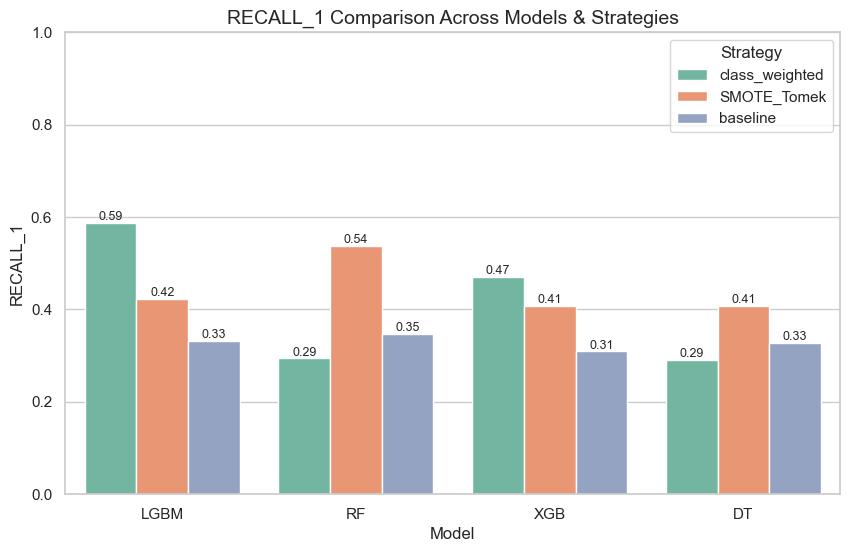

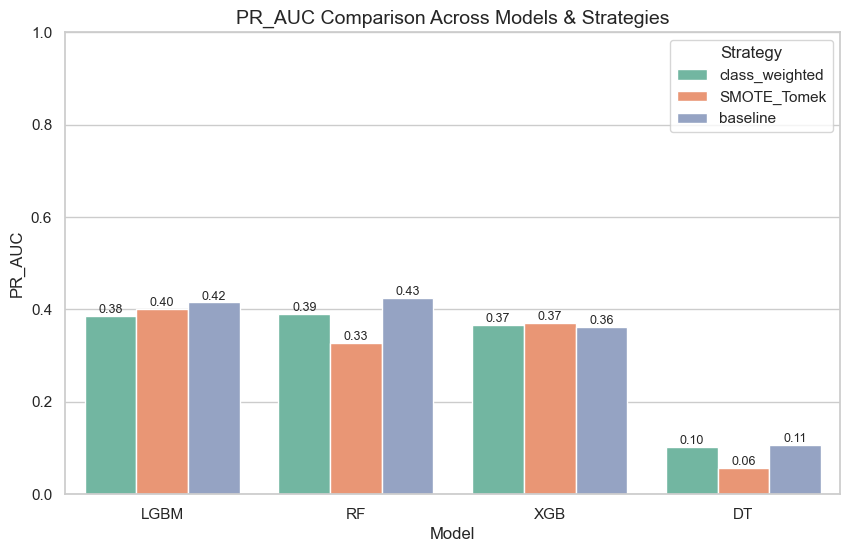

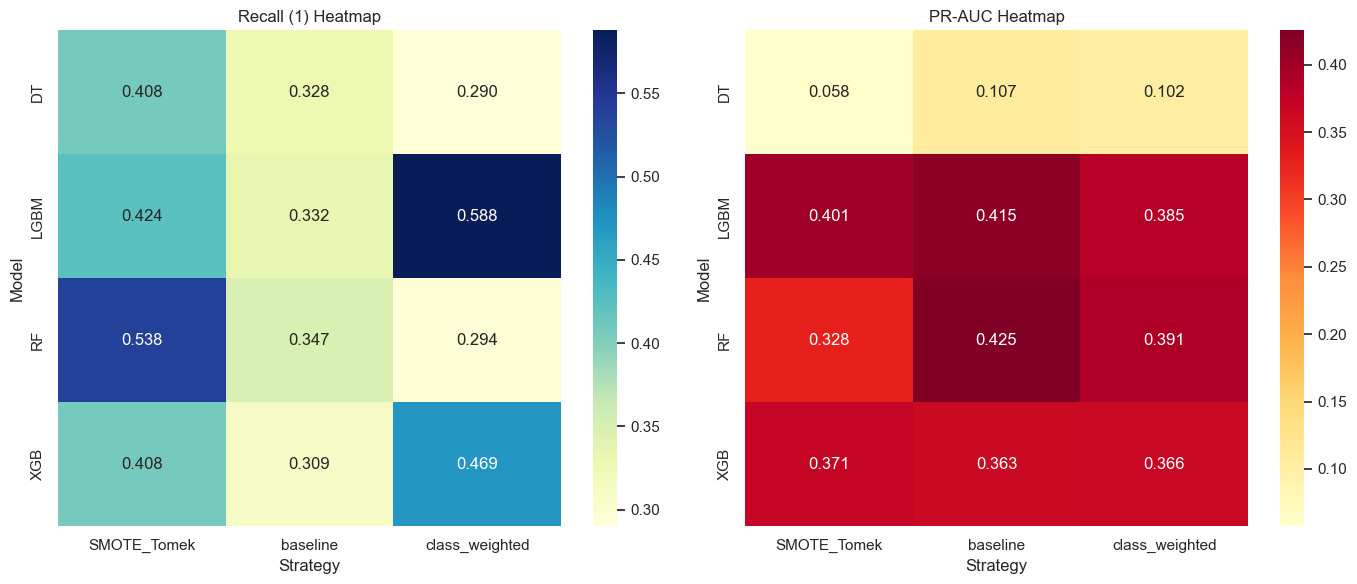

In [51]:
# 1️ Add a "strategy" column to each result dataframe
baseline_fe_aug_df = baseline_fe_aug_df.copy()
baseline_fe_aug_df['strategy'] = 'baseline'

fe_aug_class_weighted_df = fe_aug_class_weighted_df.copy()
fe_aug_class_weighted_df['strategy'] = 'class_weighted'

fe_aug_smote_tomek_df = fe_aug_smote_tomek_df.copy()
fe_aug_smote_tomek_df['strategy'] = 'SMOTE_Tomek'

# 2️ Consolidate all results
consolidated_df = pd.concat(
    [baseline_fe_aug_df, fe_aug_class_weighted_df, fe_aug_smote_tomek_df],
    ignore_index=True
)

# 3️ Sort by recall_1 and pr_auc for easy inspection
consolidated_df.sort_values(by=['recall_1', 'pr_auc'], ascending=[False, False], inplace=True)
consolidated_df.reset_index(drop=True, inplace=True)

# 4️ Display consolidated table
display(consolidated_df)


# bar charts 
sns.set(style="whitegrid")
palette = "Set2"

metrics = ['recall_1', 'pr_auc']

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(
        data=consolidated_df,
        x='model',
        y=metric,
        hue='strategy',
        palette=palette
    )
    plt.title(f"{metric.upper()} Comparison Across Models & Strategies", fontsize=14)
    plt.ylabel(metric.upper())
    plt.xlabel("Model")
    plt.ylim(0, 1)  # All metrics are between 0 and 1
    plt.legend(title='Strategy')
    # Annotate bars
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:
            plt.gca().annotate(f"{height:.2f}", 
                               (p.get_x() + p.get_width() / 2., height),
                               ha='center', va='bottom', fontsize=9)
    plt.show()


# Heatmap of Recall and PR-AUC
# Pivot table: models as rows, strategies as columns
recall_heatmap = consolidated_df.pivot(index='model', columns='strategy', values='recall_1')
pr_auc_heatmap = consolidated_df.pivot(index='model', columns='strategy', values='pr_auc')

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(recall_heatmap, annot=True, fmt=".3f", cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Recall (1) Heatmap", fontsize=12)
axes[0].set_ylabel("Model")
axes[0].set_xlabel("Strategy")

sns.heatmap(pr_auc_heatmap, annot=True, fmt=".3f", cmap="YlOrRd", ax=axes[1])
axes[1].set_title("PR-AUC Heatmap", fontsize=12)
axes[1].set_ylabel("Model")
axes[1].set_xlabel("Strategy")

plt.tight_layout()
plt.show()

This analysis compares three **finalized modeling strategies** using a fixed, feature-augmented representation:
- **Baseline (derived features)**
- **Class-weighted learning**
- **SMOTE-Tomek resampling**

The objective is to identify the **most effective and deployable strategy** by balancing recall improvement against precision loss and overall stability.

---

**1️. Comparisons Considered**

- We are comparing models (DT, RF, LGBM, XGB) across strategies:
  - baseline (feature-augmented, no imbalance handling)
  - class_weighted (feature-augmented with class weights)
  - SMOTE_Tomek (feature-augmented with data-level resampling)

- Metrics Focused:
  - recall_1: capture of the minority class (machine failure = 1)
  - pr_auc: overall precision-recall trade-off, balances precision vs recall

> Since the data is highly imbalanced, we prioritize recall, but also consider PR-AUC to avoid extremely noisy models with many false positives.

---

**2. Model-wise Observations**

- **Random Forest (RF)**
  - baseline: recall 0.347, PR-AUC 0.425 → decent PR-AUC but moderate recall
  - class_weighted: recall 0.294, PR-AUC 0.391 → recall drops; PR-AUC drops slightly
  - SMOTE_Tomek: recall 0.538, PR-AUC 0.328 → recall improves significantly but PR-AUC drops → more false positives
> Insight: RF with SMOTE-Tomek boosts recall but at cost of PR-AUC; baseline provides more balanced precision-recall tradeoff.

- **LightGBM (LGBM)**
  - baseline: recall 0.332, PR-AUC 0.415 → moderate recall with decent PR-AUC
  - class_weighted: recall 0.588, PR-AUC 0.385 → recall improves substantially; PR-AUC slightly drops → still acceptable
  - SMOTE_Tomek: recall 0.424, PR-AUC 0.401 → recall improves moderately; PR-AUC slightly better than class_weighted
> Insight: LGBM benefits strongly from class weighting, achieving high recall with reasonable PR-AUC → most promising candidate.

- **XGBoost (XGB)**
  - baseline: recall 0.309, PR-AUC 0.363 → baseline recall low, PR-AUC moderate
  - class_weighted: recall 0.469, PR-AUC 0.366 → recall improves; PR-AUC almost same → acceptable improvement
  - SMOTE_Tomek: recall 0.408, PR-AUC 0.371 → recall improves; PR-AUC slightly better
> Insight: XGB with class_weighted achieves good recall without sacrificing PR-AUC → competitive choice.

- **Decision Tree (DT)**
  - baseline: recall 0.328, PR-AUC 0.107 → very poor capture of failures
  - class_weighted: recall 0.290, PR-AUC 0.102 → slightly worse
  - SMOTE_Tomek: recall 0.408, PR-AUC 0.058 → recall improves but PR-AUC drops drastically → many false positives
> Insight: DT is not competitive; even with resampling or class weighting, PR-AUC is extremely low → unreliable.

---

##### **Final Selected Models**

>**Model 1 -> LightGBM + Class Weighting**
**Primary Objective:** *Maximize failure detection (Recall)*

**Why this combination is selected**
- Achieves the **highest recall** among all evaluated configurations, indicating strong capability to detect rare machine failures.
- Class weighting directly aligns the learning objective with the **cost-sensitive nature of predictive maintenance**, where missed failures are more expensive than false alarms.
- Maintains acceptable PR-AUC, confirming that recall gains are not achieved at the cost of completely unreliable ranking.

**How this should be interpreted**
- This configuration is suitable when the business priority is **aggressive failure prevention**, such as:
  - Safety-critical systems
  - High-cost equipment where failure consequences are severe
- The model is expected to generate more alerts, but it significantly reduces the risk of undetected failures.

**Positioning**
- **Failure-detection–focused model**
- Preferred when recall is the dominant KPI

---

>**Model 2 -> Random Forest + Baseline**
**Primary Objective:** *Reliable risk prioritization with controlled false alarms*

**Why this combination is selected**
- Delivers the **highest PR-AUC** across all configurations, indicating superior ability to **rank machines by failure risk**.
- Maintains high precision, reducing unnecessary maintenance actions.
- Feature-augmented inputs already capture much of the failure signal, making additional imbalance handling unnecessary for this model.

**How this should be interpreted**
- This configuration is suitable when the goal is to:
  - Prioritize inspections
  - Allocate maintenance resources efficiently
  - Avoid operational overload caused by excessive false positives

**Positioning**
- **Risk-ranking and decision-support model**
- Preferred when maintenance capacity and cost efficiency matter

---

**Why SMOTE-Tomek Is Not Finalized**

Although SMOTE-Tomek showed **competitive performance** for some models (notably LightGBM), it is **not selected as a final strategy** for the following reasons:

- SMOTE-based techniques introduce **synthetic failure samples**, which may not always reflect real operational behavior.
- In industrial settings, data-level resampling is used **selectively**, often with caution, due to:
  - Traceability concerns
  - Risk of overfitting to synthetic patterns
- In this project, SMOTE-Tomek did not provide **clear, consistent advantages** over class weighting or baseline strategies once PR-AUC and recall were jointly considered.

**Conclusion on SMOTE**
- SMOTE-Tomek is valid as an **experimental benchmarking technique**
- It is **not preferred as a default production strategy** in this context

---

**Final Decision Summary**

| Model | Strategy | Primary Strength | Recommended Use Case |
|-----|---------|------------------|---------------------|
| LightGBM | Class Weighting | Maximum failure detection | Safety-critical or high-risk environments |
| Random Forest | Baseline | Best risk ranking (PR-AUC) | Maintenance prioritization and planning |

---

**Final Conclusion**

There is no single “best” model for predictive maintenance—model choice depends on **how predictions are operationally used**.

- **LightGBM + Class Weighting** is selected for scenarios where **missing a failure is unacceptable**.
- **Random Forest + Baseline** is selected for scenarios where **machines must be reliably ranked by risk** to optimize maintenance decisions.

These two configurations represent **complementary and industry-aligned solutions**, forming a strong foundation for the final modeling and deployment stages of this project.

---

**Next Modeling Steps**

1. **Threshold Optimization**
   - Perform decision-threshold tuning for both finalized models.
   - Adjust thresholds to align recall–precision trade-offs with operational risk tolerance.

2. **Final Model Confirmation**
   - Validate post-threshold performance using recall and PR-AUC.
   - Select operating points suitable for deployment scenarios.

3. **Transition to Production-Grade Modeling**
   - Move finalized configurations into the `src/` pipeline.
   - Perform controlled hyperparameter tuning using **Optuna**.
   - Track experiments and model versions using **MLflow**.

---

This concludes the exploratory and decision-making phase of the project and establishes a clear, evidence-backed foundation for final optimization and deployment readiness.

### 5. Threshold Optimization

[LightGBM] [Info] Number of positive: 1048, number of negative: 71715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1544
[LightGBM] [Info] Number of data points in the train set: 72763, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LGBM_class_weighted -> Optimal Threshold: 0.93
RF_baseline -> Optimal Threshold: 0.40


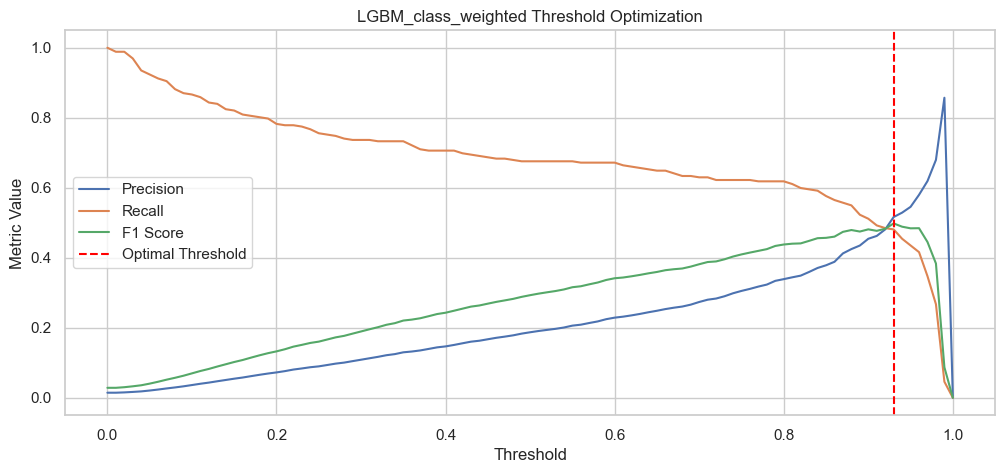

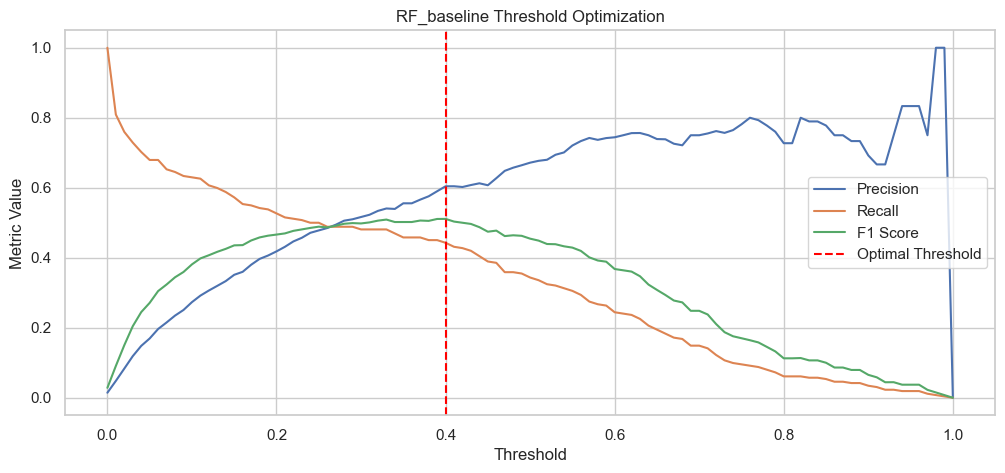

,model,optimal_threshold,precision_1,recall_1,f1_1
0,LGBM_class_weighted,0.93,0.516393,0.480916,0.498024
1,RF_baseline,0.40,0.604167,0.442748,0.511013


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

# -------------------------
# 1️⃣ Define models
# -------------------------
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# LightGBM + Class Weighting
lgbm_model = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_model.fit(X_train_fe_aug, y_train)

# Random Forest + Baseline
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_fe_aug, y_train)

final_models = {
    "LGBM_class_weighted": lgbm_model,
    "RF_baseline": rf_model
}

# -------------------------
# 2️⃣ Threshold Optimization Function
# -------------------------
def optimize_threshold(model, X_test, y_test, thresholds=np.arange(0.0, 1.01, 0.01)):
    y_prob = model.predict_proba(X_test)[:,1]
    metrics = []
    
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        metrics.append([t, precision, recall, f1])
    
    metrics_df = pd.DataFrame(metrics, columns=['threshold', 'precision', 'recall', 'f1'])
    
    # Optimal threshold: Max F1
    optimal_idx = metrics_df['f1'].idxmax()
    optimal_threshold = metrics_df.loc[optimal_idx, 'threshold']
    
    return metrics_df, optimal_threshold

# -------------------------
# 3️⃣ Run threshold optimization for both models
# -------------------------
results_threshold = {}

for name, model in final_models.items():
    metrics_df, opt_thresh = optimize_threshold(model, X_test_fe_aug, y_test)
    results_threshold[name] = {
        "metrics_df": metrics_df,
        "optimal_threshold": opt_thresh,
        "y_prob": model.predict_proba(X_test_fe_aug)[:,1]
    }
    print(f"{name} -> Optimal Threshold: {opt_thresh:.2f}")

# -------------------------
# 4️⃣ Visualization
# -------------------------
for name, result in results_threshold.items():
    metrics_df = result['metrics_df']
    
    plt.figure(figsize=(12,5))
    
    # Precision-Recall vs Threshold
    plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision')
    plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall')
    plt.plot(metrics_df['threshold'], metrics_df['f1'], label='F1 Score')
    plt.axvline(result['optimal_threshold'], color='red', linestyle='--', label='Optimal Threshold')
    
    plt.title(f"{name} Threshold Optimization")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------
# 5️⃣ Final Metrics Table at Optimal Threshold
# -------------------------
final_metrics_list = []

for name, result in results_threshold.items():
    t = result['optimal_threshold']
    y_pred_opt = (result['y_prob'] >= t).astype(int)
    precision = precision_score(y_test, y_pred_opt, zero_division=0)
    recall = recall_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt)
    
    final_metrics_list.append({
        "model": name,
        "optimal_threshold": t,
        "precision_1": precision,
        "recall_1": recall,
        "f1_1": f1
    })

final_threshold_metrics_df = pd.DataFrame(final_metrics_list)
final_threshold_metrics_df
